In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import time
import os
import pickle
import json
import timeit
import datetime
from copy import deepcopy as copy

In [2]:
import torch
from torch.nn import functional as F
torch.cuda.empty_cache()
DTYPE = torch.float32
DEVICE = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=3)

In [3]:
import sys
sys.path.append('../../')

In [4]:
import IPS_surrogate_util as util

In [5]:
beam_frequency = 80.5e6
wavelength = 299792458 / beam_frequency
phase_scan = np.arange(256)/256*2*np.pi-np.pi

cav_type_name = 'QWR085' 

In [6]:
WuLEVEL = 15
TEST = False

BATCH_SIZE = 2**13 #8192
LR = '1E-4'
DROPOUT = False

validation_split = 0.3
hidden_nodes = [128,64,64,64,64]
linear_nodes = 256
activation = torch.nn.ELU()

lr_scheduler = {'final_div_factor':1e3}

In [7]:
import sys
sys.path.insert(0, '/home/hwang/libIPS')

from info import info
for k,v in info.items():
    print(k)
    for k_,v_ in v.items():
        print(' ',k_+' '*(22-len(k_)),v_)

QWR041
  W_u_range              [450000.0, 3500000.0]
  field_amplitude_range  [0.0, 6.0]
  cav_length             0.24
  qA_range               [0.1, 0.6]
  nLEVEL                 16
QWR085
  W_u_range              [1000000.0, 33000000.0]
  field_amplitude_range  [0.0, 6.0]
  cav_length             0.32
  qA_range               [0.1, 0.6]
  nLEVEL                 16
QWR029
  W_u_range              [12000000.0, 75000000.0]
  field_amplitude_range  [0.0, 8.0]
  cav_length             0.33
  qA_range               [0.2, 0.6]
  nLEVEL                 4
QWR053
  W_u_range              [35000000.0, 320000000.0]
  field_amplitude_range  [0.0, 8.0]
  cav_length             0.49
  qA_range               [0.2, 0.6]
  nLEVEL                 4
MGB
  W_u_range              [10000000.0, 30000000.0]
  field_amplitude_range  [0.0, 8.5]
  cav_length             1.2
  qA_range               [0.2, 0.6]
  nLEVEL                 4


In [8]:
W_u_range = info[cav_type_name]['W_u_range']
field_amplitude_range = info[cav_type_name]['field_amplitude_range']
qA_range = info[cav_type_name]['qA_range']
cav_length = info[cav_type_name]['cav_length']
nLEVEL = info[cav_type_name]['nLEVEL']

In [9]:
dW_LEVEL = (W_u_range[1]-W_u_range[0])/nLEVEL
W_u_min = W_u_range[0] +WuLEVEL*dW_LEVEL 
W_u_max = W_u_range[0] +WuLEVEL*dW_LEVEL + 1.0*dW_LEVEL

In [10]:
DATA_PATH = "./data/"
MODEL_PATH = "./WuLEVEL"+str(WuLEVEL)#+"_batchsize"+str(BATCH_SIZE)+"_lr"+LR+'_'+'dtype'+str(DTYPE)[-2:]
if DTYPE == torch.float64:
    MODEL_PATH += '_dtype'+str(DTYPE)[-2:]
MODEL_PATH += '/'
LR = float(LR)
os.makedirs(MODEL_PATH, exist_ok=True)

In [11]:
EPOCHs = 6000  # may increase later... 
if TEST:
    EPOCHs = 100 #int(0.01*EPOCHs)

In [12]:
def Wu2beta(w_u):
    gamma = 1.+w_u/931.5e6
    return np.sqrt(1.0 - 1.0 / gamma ** 2)
def beta2Wu(beta):
    gamma = np.sqrt(1./(1.-beta**2))
    return (gamma-1.)*931.5e6

# Read data of selected Wu level

In [13]:
fname = os.path.join(DATA_PATH,cav_type_name+'_pd'+str(WuLEVEL)+'.pkl')
# fname = os.path.join('./',cav_type_name+'_pd'+str(WuLEVEL)+'.pkl')
df = pd.DataFrame(pickle.load(open(fname,'rb')))
df.columns

Index(['phase', 'W/u in', 'Cav amplitude in', 'qA', 'dTau', 'dW_u'], dtype='object')

### construct minmax scalar

In [14]:
Y_LABELs = ['dTau', 'dW_u']
y = df[Y_LABELs].values

Y_MIN = y.min(axis=0) #util.format_floats(y.min(axis=0),num_digits=4)
Y_MAX = y.max(axis=0) #util.format_floats(y.max(axis=0),num_digits=4)
print("Y_LABELs",Y_LABELs)
print("Y_MIN",Y_MIN)
print("Y_MAX",Y_MAX)
print("y.shape",y.shape)

Y_LABELs ['dTau', 'dW_u']
Y_MIN [-1.28658325e-02 -5.97149166e+05]
Y_MAX [1.26179265e-02 5.92324525e+05]
y.shape (134217728, 2)


In [15]:
X_LABELs = ['phase', 'W/u in', 'Cav amplitude in', 'qA']
x = df[X_LABELs].values

X_MIN = [ 0,W_u_min,                       0, qA_range[0]]
X_MAX = [ 1,W_u_max,field_amplitude_range[1], qA_range[1]] 

print("X_LABELs",X_LABELs)
print("X_MIN",X_MIN)
print("X_MAX",X_MAX)

X_LABELs ['phase', 'W/u in', 'Cav amplitude in', 'qA']
X_MIN [0, 31000000.0, 0, 0.1]
X_MAX [1, 33000000.0, 6.0, 0.6]


In [16]:
normalization_info = {'xmin':X_MIN,'xmax':X_MAX,
                      'ymin':Y_MIN,'ymax':Y_MAX,
                      'fname':MODEL_PATH+'scalar_info.pkl'}
scalar = util.scalar(**normalization_info)

### apply normalization

In [17]:
# p = np.random.permutation(len(x))
# x = x[p]
# y = y[p]

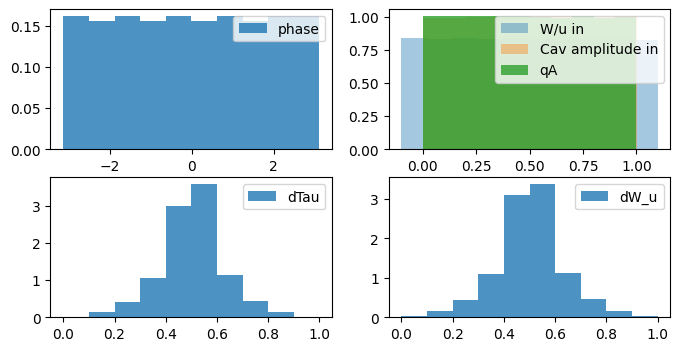

In [18]:
xn = scalar.normalize_x(x)
yn = scalar.normalize_y(y)
fig,ax = plt.subplots(2,2,figsize=(8,4))
ax[0,0].hist(xn[:,0],alpha=0.8,density=True,label=X_LABELs[0]);
ax[0,0].legend()
ax[0,1].hist(xn[:,1],alpha=0.4,density=True,label=X_LABELs[1]);
ax[0,1].hist(xn[:,2],alpha=0.4,density=True,label=X_LABELs[2]);
ax[0,1].hist(xn[:,3],alpha=0.8,density=True,label=X_LABELs[3]);
ax[0,1].legend()
ax[1,0].hist(yn[:,0],alpha=0.8,density=True,label=Y_LABELs[0]);
ax[1,0].legend()
ax[1,1].hist(yn[:,1],alpha=0.8,density=True,label=Y_LABELs[1]);
ax[1,1].legend()

# Train 

In [19]:
model, model_info = util.construct_model(
                                        input_dim  = xn.shape[1],
                                        output_dim  = yn.shape[1],
                                        input_phase_feature_dim = 1,        
                                        linear_nodes = linear_nodes,
                                        hidden_nodes = hidden_nodes,
                                        activation = activation)
model.to(DEVICE).to(DTYPE);

In [20]:
p = model.parameters().__next__()
p.dtype, p.device

(torch.float32, device(type='cuda', index=3))

In [21]:
json.dump(model_info,open(MODEL_PATH+'model_info.json','w'))
model_info

{'input_dim': 4,
 'output_dim': 2,
 'input_phase_feature_dim': 1,
 'linear_nodes': [256],
 'hidden_nodes': [128, 64, 64, 64, 64],
 'activation': 'ELU'}

In [22]:
torch.nn.MSELoss.__name__

'MSELoss'

In [23]:
train_info = {
    'epochs':EPOCHs,
    'lr':LR,
    'batch_size':BATCH_SIZE,
    'criterion': torch.nn.MSELoss.__name__,
    'optimizer': torch.optim.Adam.__name__,
    'optim_args': None,
    'lr_scheduler': lr_scheduler,
    'dropout_stabilization': DROPOUT,
    'shuffle':True,
    'load_best':True,
    'validation_split':validation_split,
    'fname_model'  : MODEL_PATH + 'model.pt',
    'fname_opt'    : MODEL_PATH + 'optimizer.pt',
    'fname_history': MODEL_PATH + 'train_history.pkl'\
}

In [ ]:
history,model_state_dict,opt_state_dict = util.train(
    model,xn,yn,
    **train_info,
    verbose = True,
    )

Train Function Arguments: 2024-04-18 17:27
  - model: _ModelWithPhaseInput
  - x: (134217728, 4)
  - y: (134217728, 2)
  - epochs: 6000
  - lr: 0.0001
  - batch_size: 8192
  - shuffle: True
  - validation_split: 0.3
  - criterion: MSELoss
  - optimizer: Adam
  - optim_args: None
  - optimizer_state_dict: None
  - lr_scheduler: {'final_div_factor': 1000.0}
  - dropout_stabilization: False
  - prev_history: None
  - load_best: True
  - training_timeout: inf
  - verbose: True
  - fname_model: ./WuLEVEL15/model.pt
  - fname_opt: ./WuLEVEL15/optimizer.pt
  - fname_history: ./WuLEVEL15/train_history.pkl

Model Paramers:
  - name: linear_base.0.weight, shape: torch.Size([256, 5]), dtype: torch.float32, device: cuda:3
  - name: linear_base.0.bias, shape: torch.Size([256]), dtype: torch.float32, device: cuda:3
  - name: linear_base.1.weight, shape: torch.Size([2, 256]), dtype: torch.float32, device: cuda:3
  - name: linear_base.1.bias, shape: torch.Size([2]), dtype: torch.float32, device: cuda:

 Epoch 0067: | Train Loss: 8.49E-08 | Val Loss: 6.54E-08 | lr: 1.92E-05 | 0:30:25.654120
 Epoch 0068: | Train Loss: 8.54E-08 | Val Loss: 1.57E-07 | lr: 1.95E-05 | 0:30:51.758370
 Epoch 0069: | Train Loss: 8.60E-08 | Val Loss: 1.10E-07 | lr: 1.98E-05 | 0:31:23.017277
 Epoch 0070: | Train Loss: 8.63E-08 | Val Loss: 6.26E-08 | lr: 2.01E-05 | 0:31:49.528947
 Epoch 0071: | Train Loss: 8.69E-08 | Val Loss: 8.37E-08 | lr: 2.04E-05 | 0:32:15.282972
 Epoch 0072: | Train Loss: 8.77E-08 | Val Loss: 5.48E-08 | lr: 2.08E-05 | 0:32:40.454594
 Epoch 0073: | Train Loss: 8.85E-08 | Val Loss: 5.65E-08 | lr: 2.11E-05 | 0:33:06.915562
 Epoch 0074: | Train Loss: 8.87E-08 | Val Loss: 6.07E-08 | lr: 2.14E-05 | 0:33:33.764413
 Epoch 0075: | Train Loss: 8.98E-08 | Val Loss: 1.50E-07 | lr: 2.18E-05 | 0:34:01.142320
 Epoch 0076: | Train Loss: 9.10E-08 | Val Loss: 6.28E-08 | lr: 2.21E-05 | 0:34:28.529705
 Epoch 0077: | Train Loss: 9.16E-08 | Val Loss: 9.25E-08 | lr: 2.24E-05 | 0:34:55.095499
 Epoch 0078: | Train 

 Epoch 0160: | Train Loss: 3.30E-07 | Val Loss: 2.08E-07 | lr: 5.90E-05 | 1:11:08.553176
 Epoch 0161: | Train Loss: 3.31E-07 | Val Loss: 1.11E-07 | lr: 5.94E-05 | 1:11:35.205727
 Epoch 0162: | Train Loss: 3.35E-07 | Val Loss: 2.31E-06 | lr: 5.99E-05 | 1:12:00.954434
 Epoch 0163: | Train Loss: 3.36E-07 | Val Loss: 2.44E-06 | lr: 6.04E-05 | 1:12:26.526855
 Epoch 0164: | Train Loss: 3.40E-07 | Val Loss: 7.08E-08 | lr: 6.09E-05 | 1:12:53.216456
 Epoch 0165: | Train Loss: 3.42E-07 | Val Loss: 1.40E-07 | lr: 6.13E-05 | 1:13:20.715057
 Epoch 0166: | Train Loss: 3.44E-07 | Val Loss: 2.00E-07 | lr: 6.18E-05 | 1:13:47.576216
 Epoch 0167: | Train Loss: 3.47E-07 | Val Loss: 3.10E-07 | lr: 6.23E-05 | 1:14:14.595112
 Epoch 0168: | Train Loss: 3.49E-07 | Val Loss: 3.06E-07 | lr: 6.28E-05 | 1:14:42.439379
 Epoch 0169: | Train Loss: 3.50E-07 | Val Loss: 7.68E-08 | lr: 6.32E-05 | 1:15:09.393650
 Epoch 0170: | Train Loss: 3.52E-07 | Val Loss: 7.74E-08 | lr: 6.37E-05 | 1:15:38.054735
 Epoch 0171: | Train 

 Epoch 0253: | Train Loss: 2.98E-07 | Val Loss: 1.43E-07 | lr: 9.46E-05 | 1:52:26.585669
 Epoch 0254: | Train Loss: 2.96E-07 | Val Loss: 1.79E-07 | lr: 9.48E-05 | 1:52:53.149110
 Epoch 0255: | Train Loss: 2.96E-07 | Val Loss: 1.52E-06 | lr: 9.50E-05 | 1:53:20.316053
 Epoch 0256: | Train Loss: 2.93E-07 | Val Loss: 7.85E-08 | lr: 9.52E-05 | 1:53:47.438872
 Epoch 0257: | Train Loss: 2.92E-07 | Val Loss: 1.19E-07 | lr: 9.54E-05 | 1:54:15.363517
 Epoch 0258: | Train Loss: 2.91E-07 | Val Loss: 2.45E-07 | lr: 9.56E-05 | 1:54:41.429977
 Epoch 0259: | Train Loss: 2.90E-07 | Val Loss: 4.17E-08 | lr: 9.58E-05 | 1:55:07.251773
 Epoch 0260: | Train Loss: 2.88E-07 | Val Loss: 5.39E-07 | lr: 9.60E-05 | 1:55:34.153186
 Epoch 0261: | Train Loss: 2.87E-07 | Val Loss: 3.96E-08 | lr: 9.62E-05 | 1:56:01.055369
 Epoch 0262: | Train Loss: 2.85E-07 | Val Loss: 3.99E-07 | lr: 9.64E-05 | 1:56:27.155591
 Epoch 0263: | Train Loss: 2.84E-07 | Val Loss: 2.27E-06 | lr: 9.66E-05 | 1:56:52.779017
 Epoch 0264: | Train 

 Epoch 0346: | Train Loss: 1.67E-07 | Val Loss: 1.92E-08 | lr: 1.00E-04 | 2:33:48.739335
 Epoch 0347: | Train Loss: 1.65E-07 | Val Loss: 1.16E-07 | lr: 1.00E-04 | 2:34:14.343941
 Epoch 0348: | Train Loss: 1.64E-07 | Val Loss: 1.49E-08 | lr: 1.00E-04 | 2:34:40.625234
 Epoch 0349: | Train Loss: 1.63E-07 | Val Loss: 3.32E-08 | lr: 1.00E-04 | 2:35:09.741317
 Epoch 0350: | Train Loss: 1.63E-07 | Val Loss: 1.68E-08 | lr: 1.00E-04 | 2:35:36.825780
 Epoch 0351: | Train Loss: 1.62E-07 | Val Loss: 7.32E-08 | lr: 1.00E-04 | 2:36:03.794860
 Epoch 0352: | Train Loss: 1.61E-07 | Val Loss: 3.04E-08 | lr: 1.00E-04 | 2:36:30.577558
 Epoch 0353: | Train Loss: 1.60E-07 | Val Loss: 2.11E-08 | lr: 1.00E-04 | 2:36:56.604011
 Epoch 0354: | Train Loss: 1.58E-07 | Val Loss: 1.44E-07 | lr: 1.00E-04 | 2:37:23.000359
 Epoch 0355: | Train Loss: 1.58E-07 | Val Loss: 8.32E-08 | lr: 1.00E-04 | 2:37:49.544846
 Epoch 0356: | Train Loss: 1.58E-07 | Val Loss: 3.94E-08 | lr: 1.00E-04 | 2:38:15.488814
 Epoch 0357: | Train 

 Epoch 0439: | Train Loss: 1.05E-07 | Val Loss: 3.71E-07 | lr: 9.99E-05 | 3:15:14.943870
 Epoch 0440: | Train Loss: 1.05E-07 | Val Loss: 1.18E-07 | lr: 9.99E-05 | 3:15:40.542487
 Epoch 0441: | Train Loss: 1.04E-07 | Val Loss: 8.24E-08 | lr: 9.98E-05 | 3:16:07.435568
 Epoch 0442: | Train Loss: 1.04E-07 | Val Loss: 5.78E-08 | lr: 9.98E-05 | 3:16:34.336647
 Epoch 0443: | Train Loss: 1.03E-07 | Val Loss: 2.69E-08 | lr: 9.98E-05 | 3:17:01.209737
 Epoch 0444: | Train Loss: 1.03E-07 | Val Loss: 1.06E-07 | lr: 9.98E-05 | 3:17:27.016257
 Epoch 0445: | Train Loss: 1.02E-07 | Val Loss: 8.41E-09 | lr: 9.98E-05 | 3:17:53.052667
 Epoch 0446: | Train Loss: 1.02E-07 | Val Loss: 2.61E-08 | lr: 9.98E-05 | 3:18:19.057860
 Epoch 0447: | Train Loss: 1.02E-07 | Val Loss: 9.59E-09 | lr: 9.98E-05 | 3:18:45.153928
 Epoch 0448: | Train Loss: 1.01E-07 | Val Loss: 1.07E-08 | lr: 9.98E-05 | 3:19:11.663071
 Epoch 0449: | Train Loss: 1.00E-07 | Val Loss: 4.45E-08 | lr: 9.98E-05 | 3:19:38.747233
 Epoch 0450: | Train 

 Epoch 0532: | Train Loss: 7.04E-08 | Val Loss: 1.76E-07 | lr: 9.96E-05 | 3:55:56.141522
 Epoch 0533: | Train Loss: 7.07E-08 | Val Loss: 8.04E-08 | lr: 9.96E-05 | 3:56:22.739608
 Epoch 0534: | Train Loss: 6.99E-08 | Val Loss: 1.60E-07 | lr: 9.96E-05 | 3:56:49.896016
 Epoch 0535: | Train Loss: 7.03E-08 | Val Loss: 8.93E-09 | lr: 9.96E-05 | 3:57:16.906852
 Epoch 0536: | Train Loss: 6.93E-08 | Val Loss: 8.27E-08 | lr: 9.96E-05 | 3:57:43.214100
 Epoch 0537: | Train Loss: 6.93E-08 | Val Loss: 2.69E-07 | lr: 9.96E-05 | 3:58:09.832188
 Epoch 0538: | Train Loss: 6.89E-08 | Val Loss: 3.33E-08 | lr: 9.96E-05 | 3:58:36.336128
 Epoch 0539: | Train Loss: 6.89E-08 | Val Loss: 2.62E-08 | lr: 9.96E-05 | 3:59:03.252035
 Epoch 0540: | Train Loss: 6.87E-08 | Val Loss: 6.97E-08 | lr: 9.96E-05 | 3:59:30.167445
 Epoch 0541: | Train Loss: 6.82E-08 | Val Loss: 5.31E-08 | lr: 9.96E-05 | 3:59:56.751592
 Epoch 0542: | Train Loss: 6.82E-08 | Val Loss: 6.53E-08 | lr: 9.96E-05 | 4:00:23.997432
 Epoch 0543: | Train 

 Epoch 0625: | Train Loss: 5.06E-08 | Val Loss: 5.87E-09 | lr: 9.92E-05 | 4:36:53.780578
 Epoch 0626: | Train Loss: 5.02E-08 | Val Loss: 5.13E-09 | lr: 9.92E-05 | 4:37:21.178318
 Epoch 0627: | Train Loss: 5.03E-08 | Val Loss: 7.67E-09 | lr: 9.92E-05 | 4:37:47.907476
 Epoch 0628: | Train Loss: 5.00E-08 | Val Loss: 2.83E-08 | lr: 9.92E-05 | 4:38:14.012503
 Epoch 0629: | Train Loss: 4.98E-08 | Val Loss: 7.81E-09 | lr: 9.92E-05 | 4:38:40.507469
 Epoch 0630: | Train Loss: 4.98E-08 | Val Loss: 4.43E-08 | lr: 9.92E-05 | 4:39:06.738658
 Epoch 0631: | Train Loss: 4.94E-08 | Val Loss: 8.71E-08 | lr: 9.92E-05 | 4:39:33.104573
 Epoch 0632: | Train Loss: 4.93E-08 | Val Loss: 6.09E-09 | lr: 9.92E-05 | 4:39:59.691743
 Epoch 0633: | Train Loss: 4.91E-08 | Val Loss: 1.26E-08 | lr: 9.92E-05 | 4:40:29.504601
 Epoch 0634: | Train Loss: 4.93E-08 | Val Loss: 3.54E-08 | lr: 9.92E-05 | 4:40:56.894414
 Epoch 0635: | Train Loss: 4.86E-08 | Val Loss: 9.80E-09 | lr: 9.92E-05 | 4:41:24.094959
 Epoch 0636: | Train 

 Epoch 0718: | Train Loss: 3.81E-08 | Val Loss: 3.88E-09 | lr: 9.87E-05 | 5:18:25.301631
 Epoch 0719: | Train Loss: 3.80E-08 | Val Loss: 5.67E-09 | lr: 9.87E-05 | 5:18:52.970158
 Epoch 0720: | Train Loss: 3.79E-08 | Val Loss: 3.12E-08 | lr: 9.87E-05 | 5:19:21.953950
 Epoch 0721: | Train Loss: 3.80E-08 | Val Loss: 7.22E-08 | lr: 9.87E-05 | 5:19:51.884821
 Epoch 0722: | Train Loss: 3.76E-08 | Val Loss: 5.92E-09 | lr: 9.87E-05 | 5:20:18.867648
 Epoch 0723: | Train Loss: 3.77E-08 | Val Loss: 4.53E-09 | lr: 9.86E-05 | 5:20:45.584030
 Epoch 0724: | Train Loss: 3.74E-08 | Val Loss: 1.66E-08 | lr: 9.86E-05 | 5:21:12.975862
 Epoch 0725: | Train Loss: 3.74E-08 | Val Loss: 9.42E-09 | lr: 9.86E-05 | 5:21:39.462318
 Epoch 0726: | Train Loss: 3.77E-08 | Val Loss: 6.04E-08 | lr: 9.86E-05 | 5:22:05.949849
 Epoch 0727: | Train Loss: 3.69E-08 | Val Loss: 6.07E-08 | lr: 9.86E-05 | 5:22:34.080775
 Epoch 0728: | Train Loss: 3.70E-08 | Val Loss: 2.12E-08 | lr: 9.86E-05 | 5:23:00.774497
 Epoch 0729: | Train 

 Epoch 0811: | Train Loss: 2.99E-08 | Val Loss: 1.08E-07 | lr: 9.80E-05 | 6:00:01.185352
 Epoch 0812: | Train Loss: 2.97E-08 | Val Loss: 1.48E-07 | lr: 9.80E-05 | 6:00:29.725937
 Epoch 0813: | Train Loss: 2.99E-08 | Val Loss: 5.23E-09 | lr: 9.80E-05 | 6:01:13.279012
 Epoch 0814: | Train Loss: 2.96E-08 | Val Loss: 5.49E-09 | lr: 9.80E-05 | 6:01:49.151939
 Epoch 0815: | Train Loss: 2.97E-08 | Val Loss: 3.79E-09 | lr: 9.80E-05 | 6:02:15.043022
 Epoch 0816: | Train Loss: 2.95E-08 | Val Loss: 2.70E-08 | lr: 9.80E-05 | 6:02:40.528820
 Epoch 0817: | Train Loss: 2.95E-08 | Val Loss: 5.27E-09 | lr: 9.80E-05 | 6:03:05.846030
 Epoch 0818: | Train Loss: 2.94E-08 | Val Loss: 5.24E-09 | lr: 9.80E-05 | 6:03:31.822330
 Epoch 0819: | Train Loss: 2.94E-08 | Val Loss: 4.87E-09 | lr: 9.80E-05 | 6:03:57.032217
 Epoch 0820: | Train Loss: 2.92E-08 | Val Loss: 1.07E-08 | lr: 9.80E-05 | 6:04:22.679283
 Epoch 0821: | Train Loss: 2.91E-08 | Val Loss: 1.07E-08 | lr: 9.80E-05 | 6:04:48.191952
 Epoch 0822: | Train 

 Epoch 0904: | Train Loss: 2.41E-08 | Val Loss: 3.07E-08 | lr: 9.73E-05 | 6:42:11.922551
 Epoch 0905: | Train Loss: 2.40E-08 | Val Loss: 5.90E-09 | lr: 9.72E-05 | 6:42:39.187774
 Epoch 0906: | Train Loss: 2.40E-08 | Val Loss: 2.67E-08 | lr: 9.72E-05 | 6:43:06.755691
 Epoch 0907: | Train Loss: 2.39E-08 | Val Loss: 4.86E-08 | lr: 9.72E-05 | 6:43:32.611003
 Epoch 0908: | Train Loss: 2.39E-08 | Val Loss: 4.11E-09 | lr: 9.72E-05 | 6:43:59.054525
 Epoch 0909: | Train Loss: 2.39E-08 | Val Loss: 3.29E-09 | lr: 9.72E-05 | 6:44:24.847778
 Epoch 0910: | Train Loss: 2.36E-08 | Val Loss: 1.20E-08 | lr: 9.72E-05 | 6:44:51.720691
 Epoch 0911: | Train Loss: 2.38E-08 | Val Loss: 5.00E-09 | lr: 9.72E-05 | 6:45:32.379789
 Epoch 0912: | Train Loss: 2.37E-08 | Val Loss: 5.28E-08 | lr: 9.72E-05 | 6:46:05.675007
 Epoch 0913: | Train Loss: 2.37E-08 | Val Loss: 6.25E-09 | lr: 9.72E-05 | 6:46:35.351153
 Epoch 0914: | Train Loss: 2.37E-08 | Val Loss: 1.86E-08 | lr: 9.72E-05 | 6:47:03.711171
 Epoch 0915: | Train 

 Epoch 0997: | Train Loss: 2.02E-08 | Val Loss: 2.98E-09 | lr: 9.64E-05 | 7:24:49.866868
 Epoch 0998: | Train Loss: 2.02E-08 | Val Loss: 3.34E-09 | lr: 9.63E-05 | 7:25:16.798121
 Epoch 0999: | Train Loss: 2.00E-08 | Val Loss: 3.55E-09 | lr: 9.63E-05 | 7:25:43.514275
 Epoch 1000: | Train Loss: 2.00E-08 | Val Loss: 4.09E-09 | lr: 9.63E-05 | 7:26:11.114683
 Epoch 1001: | Train Loss: 2.01E-08 | Val Loss: 5.96E-09 | lr: 9.63E-05 | 7:26:38.097426
 Epoch 1002: | Train Loss: 2.00E-08 | Val Loss: 5.58E-09 | lr: 9.63E-05 | 7:27:05.114296
 Epoch 1003: | Train Loss: 2.00E-08 | Val Loss: 1.04E-08 | lr: 9.63E-05 | 7:27:30.975947
 Epoch 1004: | Train Loss: 1.99E-08 | Val Loss: 1.92E-08 | lr: 9.63E-05 | 7:27:58.500203
 Epoch 1005: | Train Loss: 2.00E-08 | Val Loss: 4.86E-09 | lr: 9.63E-05 | 7:28:26.440594
 Epoch 1006: | Train Loss: 1.98E-08 | Val Loss: 2.08E-08 | lr: 9.63E-05 | 7:28:51.838849
 Epoch 1007: | Train Loss: 1.98E-08 | Val Loss: 1.42E-08 | lr: 9.63E-05 | 7:29:17.963918
 Epoch 1008: | Train 

 Epoch 1090: | Train Loss: 1.74E-08 | Val Loss: 2.89E-09 | lr: 9.53E-05 | 8:05:57.004757
 Epoch 1091: | Train Loss: 1.73E-08 | Val Loss: 4.97E-09 | lr: 9.53E-05 | 8:06:22.947229
 Epoch 1092: | Train Loss: 1.73E-08 | Val Loss: 7.88E-09 | lr: 9.53E-05 | 8:06:48.717137
 Epoch 1093: | Train Loss: 1.73E-08 | Val Loss: 8.60E-09 | lr: 9.53E-05 | 8:07:15.300934
 Epoch 1094: | Train Loss: 1.72E-08 | Val Loss: 4.47E-09 | lr: 9.53E-05 | 8:07:42.315370
 Epoch 1095: | Train Loss: 1.72E-08 | Val Loss: 4.31E-08 | lr: 9.53E-05 | 8:08:09.556026
 Epoch 1096: | Train Loss: 1.72E-08 | Val Loss: 3.12E-09 | lr: 9.53E-05 | 8:08:36.403916
 Epoch 1097: | Train Loss: 1.71E-08 | Val Loss: 1.55E-08 | lr: 9.53E-05 | 8:09:03.507489
 Epoch 1098: | Train Loss: 1.72E-08 | Val Loss: 6.24E-09 | lr: 9.52E-05 | 8:09:30.767244
 Epoch 1099: | Train Loss: 1.72E-08 | Val Loss: 1.12E-08 | lr: 9.52E-05 | 8:09:56.678536
 Epoch 1100: | Train Loss: 1.71E-08 | Val Loss: 3.55E-08 | lr: 9.52E-05 | 8:10:21.890924
 Epoch 1101: | Train 

 Epoch 1183: | Train Loss: 1.51E-08 | Val Loss: 3.11E-09 | lr: 9.42E-05 | 8:47:20.867341
 Epoch 1184: | Train Loss: 1.50E-08 | Val Loss: 3.39E-09 | lr: 9.42E-05 | 8:47:47.438618
 Epoch 1185: | Train Loss: 1.50E-08 | Val Loss: 1.89E-08 | lr: 9.42E-05 | 8:48:13.052863
 Epoch 1186: | Train Loss: 1.50E-08 | Val Loss: 2.13E-09 | lr: 9.42E-05 | 8:48:39.223495
 Epoch 1187: | Train Loss: 1.49E-08 | Val Loss: 2.06E-08 | lr: 9.41E-05 | 8:49:06.550079
 Epoch 1188: | Train Loss: 1.50E-08 | Val Loss: 9.06E-09 | lr: 9.41E-05 | 8:49:34.736029
 Epoch 1189: | Train Loss: 1.49E-08 | Val Loss: 6.71E-09 | lr: 9.41E-05 | 8:50:02.069689
 Epoch 1190: | Train Loss: 1.49E-08 | Val Loss: 5.96E-09 | lr: 9.41E-05 | 8:50:29.305826
 Epoch 1191: | Train Loss: 1.49E-08 | Val Loss: 4.08E-09 | lr: 9.41E-05 | 8:50:56.769225
 Epoch 1192: | Train Loss: 1.48E-08 | Val Loss: 2.14E-08 | lr: 9.41E-05 | 8:51:24.165608
 Epoch 1193: | Train Loss: 1.49E-08 | Val Loss: 4.42E-09 | lr: 9.41E-05 | 8:51:50.728286
 Epoch 1194: | Train 

 Epoch 1276: | Train Loss: 1.32E-08 | Val Loss: 8.46E-09 | lr: 9.29E-05 | 9:28:44.719059
 Epoch 1277: | Train Loss: 1.31E-08 | Val Loss: 5.97E-09 | lr: 9.29E-05 | 9:29:11.353246
 Epoch 1278: | Train Loss: 1.31E-08 | Val Loss: 7.73E-09 | lr: 9.29E-05 | 9:29:42.426950
 Epoch 1279: | Train Loss: 1.31E-08 | Val Loss: 2.99E-09 | lr: 9.29E-05 | 9:30:08.345438
 Epoch 1280: | Train Loss: 1.30E-08 | Val Loss: 3.46E-09 | lr: 9.29E-05 | 9:30:34.292901
 Epoch 1281: | Train Loss: 1.30E-08 | Val Loss: 2.74E-09 | lr: 9.29E-05 | 9:31:00.258271
 Epoch 1282: | Train Loss: 1.31E-08 | Val Loss: 4.77E-09 | lr: 9.29E-05 | 9:31:26.830277
 Epoch 1283: | Train Loss: 1.30E-08 | Val Loss: 7.31E-09 | lr: 9.28E-05 | 9:31:52.759605
 Epoch 1284: | Train Loss: 1.29E-08 | Val Loss: 9.84E-09 | lr: 9.28E-05 | 9:32:17.948106
 Epoch 1285: | Train Loss: 1.30E-08 | Val Loss: 2.32E-09 | lr: 9.28E-05 | 9:32:43.714648
 Epoch 1286: | Train Loss: 1.30E-08 | Val Loss: 4.42E-09 | lr: 9.28E-05 | 9:33:09.398265
 Epoch 1287: | Train 

 Epoch 1368: | Train Loss: 1.15E-08 | Val Loss: 1.37E-08 | lr: 9.16E-05 | 10:09:18.057121
 Epoch 1369: | Train Loss: 1.16E-08 | Val Loss: 3.61E-09 | lr: 9.16E-05 | 10:09:45.044248
 Epoch 1370: | Train Loss: 1.16E-08 | Val Loss: 2.47E-09 | lr: 9.16E-05 | 10:10:12.152692
 Epoch 1371: | Train Loss: 1.16E-08 | Val Loss: 3.60E-09 | lr: 9.15E-05 | 10:10:38.048501
 Epoch 1372: | Train Loss: 1.15E-08 | Val Loss: 2.70E-08 | lr: 9.15E-05 | 10:11:04.566276
 Epoch 1373: | Train Loss: 1.15E-08 | Val Loss: 7.82E-09 | lr: 9.15E-05 | 10:11:30.700705
 Epoch 1374: | Train Loss: 1.15E-08 | Val Loss: 2.63E-09 | lr: 9.15E-05 | 10:11:57.128789
 Epoch 1375: | Train Loss: 1.15E-08 | Val Loss: 1.88E-09 | lr: 9.15E-05 | 10:12:23.265411
 Epoch 1376: | Train Loss: 1.15E-08 | Val Loss: 7.78E-09 | lr: 9.15E-05 | 10:12:48.710221
 Epoch 1377: | Train Loss: 1.15E-08 | Val Loss: 7.72E-08 | lr: 9.14E-05 | 10:13:15.291681
 Epoch 1378: | Train Loss: 1.14E-08 | Val Loss: 3.46E-09 | lr: 9.14E-05 | 10:13:41.712349
 Epoch 137

 Epoch 1460: | Train Loss: 1.04E-08 | Val Loss: 2.10E-09 | lr: 9.01E-05 | 10:49:56.579366
 Epoch 1461: | Train Loss: 1.04E-08 | Val Loss: 1.98E-09 | lr: 9.01E-05 | 10:50:29.246571
 Epoch 1462: | Train Loss: 1.03E-08 | Val Loss: 1.84E-09 | lr: 9.01E-05 | 10:50:55.443691
 Epoch 1463: | Train Loss: 1.03E-08 | Val Loss: 1.63E-08 | lr: 9.01E-05 | 10:51:28.590440
 Epoch 1464: | Train Loss: 1.04E-08 | Val Loss: 3.93E-09 | lr: 9.01E-05 | 10:51:59.500506
 Epoch 1465: | Train Loss: 1.02E-08 | Val Loss: 5.26E-09 | lr: 9.00E-05 | 10:52:25.446242
 Epoch 1466: | Train Loss: 1.03E-08 | Val Loss: 2.68E-09 | lr: 9.00E-05 | 10:52:51.661463
 Epoch 1467: | Train Loss: 1.03E-08 | Val Loss: 3.85E-09 | lr: 9.00E-05 | 10:53:17.750291
 Epoch 1468: | Train Loss: 1.02E-08 | Val Loss: 3.11E-09 | lr: 9.00E-05 | 10:53:43.473515
 Epoch 1469: | Train Loss: 1.02E-08 | Val Loss: 1.99E-09 | lr: 9.00E-05 | 10:54:09.322107
 Epoch 1470: | Train Loss: 1.02E-08 | Val Loss: 5.14E-09 | lr: 9.00E-05 | 10:54:35.341123
 Epoch 147

 Epoch 1552: | Train Loss: 9.29E-09 | Val Loss: 1.87E-09 | lr: 8.86E-05 | 11:30:39.627587
 Epoch 1553: | Train Loss: 9.26E-09 | Val Loss: 4.33E-09 | lr: 8.85E-05 | 11:31:05.768028
 Epoch 1554: | Train Loss: 9.24E-09 | Val Loss: 3.84E-09 | lr: 8.85E-05 | 11:31:32.164301
 Epoch 1555: | Train Loss: 9.24E-09 | Val Loss: 5.40E-09 | lr: 8.85E-05 | 11:31:57.964704
 Epoch 1556: | Train Loss: 9.22E-09 | Val Loss: 9.62E-09 | lr: 8.85E-05 | 11:32:24.863911
 Epoch 1557: | Train Loss: 9.21E-09 | Val Loss: 1.01E-08 | lr: 8.85E-05 | 11:32:51.460953
 Epoch 1558: | Train Loss: 9.25E-09 | Val Loss: 2.61E-08 | lr: 8.85E-05 | 11:33:18.668767
 Epoch 1559: | Train Loss: 9.17E-09 | Val Loss: 1.70E-09 | lr: 8.84E-05 | 11:33:45.155780
 Epoch 1560: | Train Loss: 9.15E-09 | Val Loss: 3.55E-09 | lr: 8.84E-05 | 11:34:12.180598
 Epoch 1561: | Train Loss: 9.22E-09 | Val Loss: 1.68E-09 | lr: 8.84E-05 | 11:34:38.757781
 Epoch 1562: | Train Loss: 9.12E-09 | Val Loss: 5.04E-09 | lr: 8.84E-05 | 11:35:09.461764
 Epoch 156

 Epoch 1644: | Train Loss: 8.35E-09 | Val Loss: 1.58E-08 | lr: 8.69E-05 | 12:11:40.785366
 Epoch 1645: | Train Loss: 8.31E-09 | Val Loss: 1.02E-08 | lr: 8.69E-05 | 12:12:07.130399
 Epoch 1646: | Train Loss: 8.32E-09 | Val Loss: 3.21E-09 | lr: 8.69E-05 | 12:12:33.139089
 Epoch 1647: | Train Loss: 8.34E-09 | Val Loss: 3.22E-09 | lr: 8.68E-05 | 12:12:59.019635
 Epoch 1648: | Train Loss: 8.30E-09 | Val Loss: 6.01E-09 | lr: 8.68E-05 | 12:13:25.530001
 Epoch 1649: | Train Loss: 8.31E-09 | Val Loss: 6.42E-09 | lr: 8.68E-05 | 12:13:53.308633
 Epoch 1650: | Train Loss: 8.28E-09 | Val Loss: 4.41E-09 | lr: 8.68E-05 | 12:14:19.877797
 Epoch 1651: | Train Loss: 8.27E-09 | Val Loss: 4.77E-09 | lr: 8.68E-05 | 12:14:47.113290
 Epoch 1652: | Train Loss: 8.25E-09 | Val Loss: 1.68E-09 | lr: 8.67E-05 | 12:15:13.933283
 Epoch 1653: | Train Loss: 8.27E-09 | Val Loss: 2.85E-08 | lr: 8.67E-05 | 12:15:41.370138
 Epoch 1654: | Train Loss: 8.24E-09 | Val Loss: 1.58E-09 | lr: 8.67E-05 | 12:16:07.416826
 Epoch 165

 Epoch 1736: | Train Loss: 7.58E-09 | Val Loss: 4.69E-09 | lr: 8.51E-05 | 12:52:27.956767
 Epoch 1737: | Train Loss: 7.49E-09 | Val Loss: 2.38E-09 | lr: 8.51E-05 | 12:52:54.184338
 Epoch 1738: | Train Loss: 7.48E-09 | Val Loss: 3.61E-09 | lr: 8.51E-05 | 12:53:20.054991
 Epoch 1739: | Train Loss: 7.49E-09 | Val Loss: 1.65E-08 | lr: 8.51E-05 | 12:53:46.994216
 Epoch 1740: | Train Loss: 7.50E-09 | Val Loss: 1.59E-08 | lr: 8.51E-05 | 12:54:14.156246
 Epoch 1741: | Train Loss: 7.47E-09 | Val Loss: 2.01E-09 | lr: 8.50E-05 | 12:54:40.792794
 Epoch 1742: | Train Loss: 7.47E-09 | Val Loss: 4.66E-09 | lr: 8.50E-05 | 12:55:06.685751
 Epoch 1743: | Train Loss: 7.44E-09 | Val Loss: 2.67E-09 | lr: 8.50E-05 | 12:55:32.560037
 Epoch 1744: | Train Loss: 7.48E-09 | Val Loss: 1.52E-09 | lr: 8.50E-05 | 12:55:58.293807
 Epoch 1745: | Train Loss: 7.46E-09 | Val Loss: 2.04E-09 | lr: 8.50E-05 | 12:56:23.876536
 Epoch 1746: | Train Loss: 7.39E-09 | Val Loss: 4.55E-09 | lr: 8.49E-05 | 12:56:49.228082
 Epoch 174

 Epoch 1828: | Train Loss: 6.75E-09 | Val Loss: 2.33E-09 | lr: 8.33E-05 | 13:33:18.248879
 Epoch 1829: | Train Loss: 6.76E-09 | Val Loss: 5.89E-09 | lr: 8.33E-05 | 13:33:45.262108
 Epoch 1830: | Train Loss: 6.74E-09 | Val Loss: 5.53E-09 | lr: 8.33E-05 | 13:34:11.697390
 Epoch 1831: | Train Loss: 6.76E-09 | Val Loss: 2.04E-09 | lr: 8.32E-05 | 13:34:38.157887
 Epoch 1832: | Train Loss: 6.73E-09 | Val Loss: 3.31E-09 | lr: 8.32E-05 | 13:35:04.369400
 Epoch 1833: | Train Loss: 6.73E-09 | Val Loss: 7.83E-09 | lr: 8.32E-05 | 13:35:29.532419
 Epoch 1834: | Train Loss: 6.73E-09 | Val Loss: 4.61E-09 | lr: 8.32E-05 | 13:35:55.206178
 Epoch 1835: | Train Loss: 6.74E-09 | Val Loss: 3.14E-09 | lr: 8.31E-05 | 13:36:20.814193
 Epoch 1836: | Train Loss: 6.65E-09 | Val Loss: 3.19E-09 | lr: 8.31E-05 | 13:36:47.105198
 Epoch 1837: | Train Loss: 6.71E-09 | Val Loss: 8.75E-09 | lr: 8.31E-05 | 13:37:13.250207
 Epoch 1838: | Train Loss: 6.70E-09 | Val Loss: 1.46E-09 | lr: 8.31E-05 | 13:37:40.046998
 Epoch 183

 Epoch 1920: | Train Loss: 6.07E-09 | Val Loss: 4.60E-09 | lr: 8.14E-05 | 14:14:30.963444
 Epoch 1921: | Train Loss: 6.08E-09 | Val Loss: 2.49E-09 | lr: 8.13E-05 | 14:14:57.348250
 Epoch 1922: | Train Loss: 6.08E-09 | Val Loss: 1.22E-09 | lr: 8.13E-05 | 14:15:24.252846
 Epoch 1923: | Train Loss: 6.05E-09 | Val Loss: 1.13E-08 | lr: 8.13E-05 | 14:15:50.318760
 Epoch 1924: | Train Loss: 6.03E-09 | Val Loss: 2.11E-09 | lr: 8.13E-05 | 14:16:18.007956
 Epoch 1925: | Train Loss: 6.04E-09 | Val Loss: 3.03E-09 | lr: 8.13E-05 | 14:16:45.091812
 Epoch 1926: | Train Loss: 6.04E-09 | Val Loss: 4.07E-09 | lr: 8.12E-05 | 14:17:11.097486
 Epoch 1927: | Train Loss: 6.03E-09 | Val Loss: 1.30E-09 | lr: 8.12E-05 | 14:17:36.544365
 Epoch 1928: | Train Loss: 6.03E-09 | Val Loss: 1.54E-09 | lr: 8.12E-05 | 14:18:02.574745
 Epoch 1929: | Train Loss: 6.01E-09 | Val Loss: 1.31E-09 | lr: 8.12E-05 | 14:18:28.172320
 Epoch 1930: | Train Loss: 6.01E-09 | Val Loss: 4.82E-09 | lr: 8.11E-05 | 14:18:54.162967
 Epoch 193

 Epoch 2012: | Train Loss: 5.48E-09 | Val Loss: 2.91E-09 | lr: 7.93E-05 | 14:55:11.998858
 Epoch 2013: | Train Loss: 5.46E-09 | Val Loss: 6.45E-09 | lr: 7.93E-05 | 14:55:38.746705
 Epoch 2014: | Train Loss: 5.45E-09 | Val Loss: 1.14E-08 | lr: 7.93E-05 | 14:56:05.873316
 Epoch 2015: | Train Loss: 5.43E-09 | Val Loss: 2.73E-09 | lr: 7.93E-05 | 14:56:31.574480
 Epoch 2016: | Train Loss: 5.44E-09 | Val Loss: 6.94E-09 | lr: 7.93E-05 | 14:56:57.191808
 Epoch 2017: | Train Loss: 5.45E-09 | Val Loss: 1.08E-08 | lr: 7.92E-05 | 14:57:24.026357
 Epoch 2018: | Train Loss: 5.42E-09 | Val Loss: 5.12E-09 | lr: 7.92E-05 | 14:57:54.113513
 Epoch 2019: | Train Loss: 5.41E-09 | Val Loss: 1.24E-09 | lr: 7.92E-05 | 14:58:20.298809
 Epoch 2020: | Train Loss: 5.42E-09 | Val Loss: 1.97E-09 | lr: 7.92E-05 | 14:58:45.526802
 Epoch 2021: | Train Loss: 5.43E-09 | Val Loss: 2.28E-08 | lr: 7.91E-05 | 14:59:11.439467
 Epoch 2022: | Train Loss: 5.40E-09 | Val Loss: 1.21E-09 | lr: 7.91E-05 | 14:59:37.196678
 Epoch 202

 Epoch 2104: | Train Loss: 4.91E-09 | Val Loss: 3.31E-09 | lr: 7.73E-05 | 15:36:09.264933
 Epoch 2105: | Train Loss: 4.89E-09 | Val Loss: 4.01E-09 | lr: 7.72E-05 | 15:36:36.192224
 Epoch 2106: | Train Loss: 4.91E-09 | Val Loss: 4.23E-09 | lr: 7.72E-05 | 15:37:01.970485
 Epoch 2107: | Train Loss: 4.89E-09 | Val Loss: 5.15E-09 | lr: 7.72E-05 | 15:37:28.367144
 Epoch 2108: | Train Loss: 4.89E-09 | Val Loss: 6.15E-09 | lr: 7.72E-05 | 15:37:54.822453
 Epoch 2109: | Train Loss: 4.89E-09 | Val Loss: 1.36E-09 | lr: 7.71E-05 | 15:38:20.347282
 Epoch 2110: | Train Loss: 4.86E-09 | Val Loss: 3.58E-09 | lr: 7.71E-05 | 15:38:45.977363
 Epoch 2111: | Train Loss: 4.86E-09 | Val Loss: 1.52E-09 | lr: 7.71E-05 | 15:39:12.318977
 Epoch 2112: | Train Loss: 4.86E-09 | Val Loss: 2.18E-09 | lr: 7.71E-05 | 15:39:39.072339
 Epoch 2113: | Train Loss: 4.86E-09 | Val Loss: 2.90E-09 | lr: 7.70E-05 | 15:40:06.856650
 Epoch 2114: | Train Loss: 4.84E-09 | Val Loss: 1.18E-09 | lr: 7.70E-05 | 15:40:34.190544
 Epoch 211

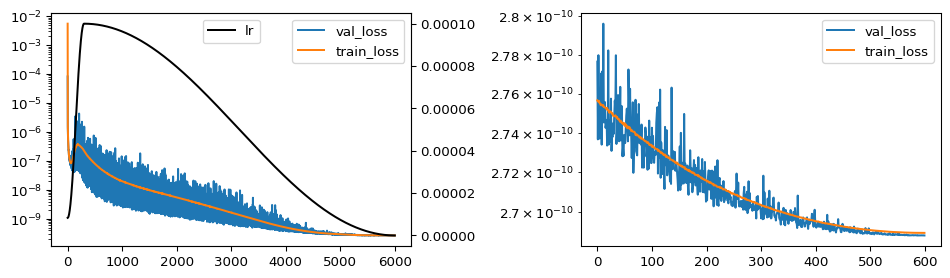

In [37]:
fig,ax=plt.subplots(1,2,figsize=(10,3),dpi=96)
ax[0].semilogy(history['val_loss'],label='val_loss')
ax[0].semilogy(history['train_loss'],label='train_loss')
ax[0].legend()
axx = ax[0].twinx()
axx.plot(history['lr'],label='lr',color='k')
axx.legend(loc='upper center')

ax[1].semilogy(history['val_loss'][-int(0.1*EPOCHs):],label='val_loss')
ax[1].semilogy(history['train_loss'][-int(0.1*EPOCHs):],label='train_loss')
ax[1].legend()
fig.tight_layout()

In [38]:
np.min(history['train_loss']), np.min(history['val_loss'])

(2.689635154013143e-10, 2.6883444248925997e-10)

# loaded model test, w jit, 

In [39]:
model_info = json.load(open(MODEL_PATH + 'model_info.json','r'))
scalar = util.scalar(fname=MODEL_PATH + 'scalar_info.pkl')

### model time cost

##### w/o JIT

In [40]:
model, _ = util.construct_model(**model_info)
model.to('cpu').to(DTYPE);
model.load_state_dict(torch.load(MODEL_PATH+'model.pt',map_location=torch.device('cpu')))
model.eval();

In [41]:
test_x = torch.tensor(xn[:1,:],dtype=DTYPE)

def test():
    model(test_x)
t = timeit.Timer(test)
dt = t.timeit(number=100000)/100000
print('dt:',dt*1e6,'micro-sec')

dt: 133.9960740879178 micro-sec


##### w JIT

In [42]:
model, _ = util.construct_model(**model_info)
model.to('cpu').to(DTYPE);
my_script_module = torch.jit.script(model)
my_script_module.load_state_dict(torch.load(MODEL_PATH+'model.pt',map_location=torch.device('cpu')))
my_script_module.eval();

In [43]:
def test():
    my_script_module(test_x)
t = timeit.Timer(test)
dt = t.timeit(number=100000)/100000
print('dt:',dt*1e6,'micro-sec')

dt: 97.7988512814045 micro-sec


# validation

In [44]:
nval = int(validation_split*len(x))
xval = xn[:nval]
yval = yn[:nval]
yval_true_phys = y[:nval]

xval.shape, yval.shape, yval_true_phys.shape

((40265318, 4), (40265318, 2), (40265318, 2))

In [45]:
BATCH_SIZE, nval, len(x)

(8192, 40265318, 134217728)

In [46]:
nbatch = int(len(xval)/BATCH_SIZE)
yval_pred = []
for i in range(nbatch):
    i1 = i*BATCH_SIZE
    i2 = i1+BATCH_SIZE
    x_ = torch.tensor(xval[i1:i2,:],dtype=DTYPE)
    with torch.no_grad():
        yval_pred.append( my_script_module(x_).cpu().numpy() )
        
x_ = torch.tensor(xval[i2:,:],dtype=DTYPE)
with torch.no_grad():
    yval_pred.append( my_script_module(x_).cpu().numpy() )
    
yval_pred_phys = scalar.unnormalize_y(np.concatenate(yval_pred,axis=0))

In [47]:
yval_pred_phys.shape, yval_true_phys.shape

((40265318, 2), (40265318, 2))

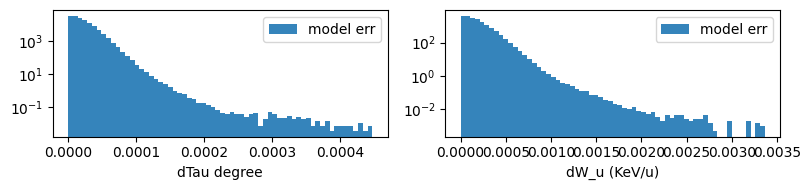

In [48]:
diff_model = np.abs(yval_pred_phys-yval_true_phys)

fig,ax = plt.subplots(1,2,figsize=(8,2))
ax[0].hist(diff_model[:,0]/np.pi*180,bins=64,label='model err',alpha=0.9,density=True)
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xlabel(Y_LABELs[0]+" degree")

ax[1].hist(diff_model[:,1]*1e-5,bins=64,label='model err',alpha=0.9,density=True)
ax[1].legend()
ax[1].set_yscale('log')
ax[1].set_xlabel(Y_LABELs[1]+" (KeV/u)")

fig.tight_layout()
fig.savefig(MODEL_PATH+'plot_validation.png',dpi=64)